In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib

import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle

from LoadData import load_data
import PlottingHelpers
import ProcessingHelpers

importlib.reload(ProcessingHelpers) # while still working on than fun
importlib.reload(PlottingHelpers) # while still working on than fun

<module 'PlottingHelpers' from 'C:\\Users\\GLA_A\\Source\\Repos\\python-ml-turbofan\\PlottingHelpers.py'>

In [2]:
sns.set() 

In [3]:
dirname = os.getcwd()
pth = os.path.join(dirname, 'CMAPSSData')

print('loading data...')
dc = load_data(pth)
print('done')

loading data...
done


In [4]:
# get the first data set training data
df = dc['FD_001']['df_train'].copy()

# Make a Column for the RUL target data (y)

According to the data description document the data set contains multiple units, each unit starts at a certain degradation point and the measurement data ends closely before the unit was decommissioned of broke. 

Therefore assume, that for the last measurement time that is available for a unit the units RUL=0 (stopped measuring just before machine broke)


In [5]:
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']

## Drop the nan columns and rows

In [6]:
cols_nan = df.columns[df.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')

cols_const = [ col for col in df.columns if len(df[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')

Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']



In [7]:
df = df.drop(columns=cols_const + cols_nan)

take out a certain percentage of units from the training data set for testing later, (additionally to the classic validation methods)


In [8]:
units = df['unit_nr'].unique()
n_units = len(df['unit_nr'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

df_test = df.loc[df['unit_nr'].apply( lambda x: x in units_test )].copy()
df_train = df.loc[df['unit_nr'].apply( lambda x: x in units_train )].copy()

## Normalize the dataset by mean and std

In [9]:
cols_features = [c for c in df_train.columns if c.startswith('s')]

train_data = df_train[cols_features].values
train_labels = df_train['RUL'].values

test_data = df_test[cols_features].values
test_labels = df_test['RUL'].values

In [10]:
# Test data is *not* used when calculating the mean and std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-1.73075884 -0.14105514 -0.93641036  1.1324805  -0.51657334 -0.86047297
 -0.27157265  0.34113999 -1.06340317 -0.28631641 -0.61070764 -0.7879295
  1.35801789  1.20373742]


In [11]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(24, activation=tf.nn.relu,
                           input_shape=(train_data.shape[1],)),
        keras.layers.Dense(24, activation=tf.nn.relu),
        keras.layers.Dense(24, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    
    return model

def plot_res(model, test_data, test_labels, train_data, train_labels):
    [loss, mae] = model.evaluate(test_data, test_labels, verbose=0)
    [loss, mae_train] = model.evaluate(train_data, train_labels, verbose=0)
    print("Testing set Mean Abs Error:  {:7.2f}".format(mae))
    print("Training set Mean Abs Error: {:7.2f}".format(mae_train))
    test_predictions = model.predict(test_data).flatten()
    train_predictions = model.predict(train_data).flatten()
    sns.distplot(train_predictions - train_labels)
    sns.distplot(test_predictions - test_labels)
    _ = plt.xlabel("Prediction Error")

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Validation loss')
    plt.legend()
    
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


In [12]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________


In [13]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)# Display training progress by printing a single dot for each completed epoch

EPOCHS=500
train_data2, train_labels2 = shuffle(train_data, train_labels)
history = model.fit(train_data2, train_labels2, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])


...............................................................

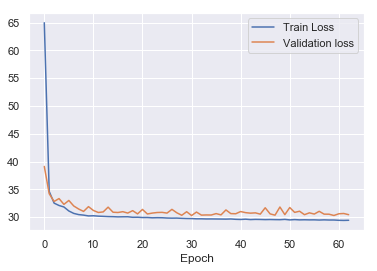

In [14]:
plot_history(history)

Testing set Mean Abs Error:    26.48
Training set Mean Abs Error:   29.39


C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


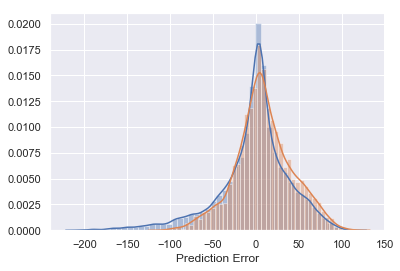

In [15]:
plot_res(model, test_data, test_labels, train_data, train_labels)

(3917, 19)
(3917,)


C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


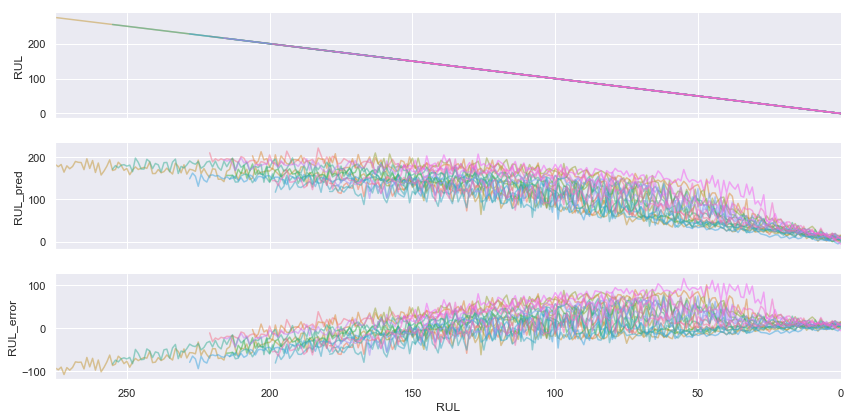

In [16]:
test_predictions = model.predict(test_data).flatten()
tmp = df_test[['RUL', 'unit_nr']]
print(df_test.shape)
print(test_predictions.shape)
tmp['RUL_error'] = test_predictions - test_labels
tmp['RUL_pred'] = test_predictions

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])